### 0) Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic
from statsmodels.tsa.api import SARIMAX

pd.set_option("display.precision", 2)

### 0) Import the file and create the two data frames

In [3]:
xls = pd.ExcelFile('Data.xlsx')
df = xls.parse(0)
factors_df = xls.parse(1)

In [4]:
df['Time'] = pd.to_datetime(df['Time'])
factors_df['Time'] = pd.to_datetime(factors_df['Time'])

Limit the observations until 2018:Q3

In [5]:
df = df.iloc[0:234]

In [6]:
df.tail()

,Time,GDPC1,PCECTPI,TB3MS,GS10
229,2017-09-30,19304.35,98.95,0.43,2.13
230,2017-12-30,19398.34,99.52,0.59,2.44
231,2018-03-30,19506.95,99.72,0.89,2.26
232,2018-06-30,19660.77,100.08,1.04,2.24
233,2018-09-30,19882.35,100.68,1.21,2.37


Create $\log(GDPC1)$ and $\Delta \log(GDPC1)$

In [7]:
df['log_GDP'] = np.log(df['GDPC1'])

df['delta_log_GDP'] = (df['log_GDP'] - df['log_GDP'].shift(1))
df['delta_log_GDP'].fillna(0, inplace=True)

Create $\pi$ and $\log(PCECTPI)$

In [8]:
df['infl'] = (np.log(df['PCECTPI']) - (np.log(df['PCECTPI'])).shift(1))
df['infl'].fillna(0, inplace=True)

df['log_PCECTPI'] = np.log(df['PCECTPI'])

Create $TSpread$

In [9]:
df['tspread'] = df['GS10'] - df['TB3MS']

### **1) Calculate Principal Component**

Create `stand_factors` as a data frame containing 245 columns, namely all the columns of factors_df except the _Time_, but standardized ($\mu =0$, $\sigma=1$).

`factors_df` doesn't change.

In [10]:
stand_factors = factors_df.iloc[:, 1:].apply(stats.zscore, axis=0)

In [11]:
stand_factors.head()

,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,A014RE1Q156NBEA,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
0,0.35,0.20,1.00,-2.75e-01,-1.83,0.06,0.64,0.73,-0.50,-0.64,...,0.98,-0.51,-0.83,-0.77,-0.75,0.17,0.07,0.10,-0.12,-0.17
1,-0.95,-2.02,0.74,-3.28e-03,0.55,-0.97,-0.49,-0.68,-0.72,0.54,...,-2.14,-0.85,-1.02,-0.49,-1.93,0.88,-0.55,-0.56,0.44,-0.61
2,0.22,0.61,0.19,-4.25e-01,2.08,1.09,0.71,1.10,0.59,2.72,...,1.90,-0.45,0.03,-0.21,1.85,-1.01,-0.71,-0.78,1.13,-0.57
3,0.65,0.31,0.56,5.51e-01,-2.57,-1.27,0.13,0.15,-1.97,0.20,...,0.43,-0.43,-0.53,-0.46,-0.43,0.10,-0.34,-0.40,0.45,-0.24
4,-1.67,-0.69,-1.63,-1.40e+00,-0.28,-1.43,-1.88,-1.40,-0.75,0.54,...,0.46,-0.51,-0.08,-0.10,-0.95,0.47,-0.38,-0.49,0.16,0.01


In [12]:
df.head()

,Time,GDPC1,PCECTPI,TB3MS,GS10,log_GDP,delta_log_GDP,infl,log_PCECTPI,tspread
0,1960-06-30,3430.06,15.33,3.54,4.50,8.14,0.00e+00,0.00e+00,2.73,0.96
1,1960-09-30,3439.83,15.41,4.23,4.58,8.14,2.85e-03,5.46e-03,2.74,0.35
2,1960-12-30,3517.18,15.44,3.87,4.49,8.17,2.22e-02,1.30e-03,2.74,0.61
3,1961-03-30,3498.25,15.52,2.99,4.26,8.16,-5.40e-03,5.17e-03,2.74,1.27
4,1961-06-30,3515.39,15.57,2.36,3.83,8.16,4.89e-03,3.80e-03,2.75,1.47


## **Model 1: Random Walk**

Since the prediction for the next period is the last observed value, all we have to do is to shift(1) the series, and then consider only the prediction starting from 1985:Q2.

In [11]:
rw_predictions = df['log_GDP'].shift(1)

# bring it into real terms
exp_rw_predictions = np.exp(rw_predictions)

# consider only from 1985:Q3
exp_rw_predictions = exp_rw_predictions[100:]

# compute RMSE for RW
rmse_rw = mean_squared_error(df['GDPC1'].iloc[100:], exp_rw_predictions, squared=False).round(2)
print(rmse_rw)

119.44


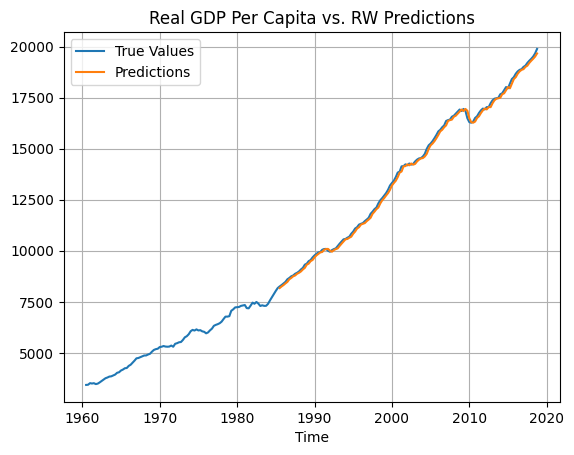

In [12]:
plt.plot(df['Time'], df['GDPC1'], label='True Values')
plt.plot(df['Time'].iloc[100:], exp_rw_predictions, label='Predictions')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.title('Real GDP Per Capita vs. RW Predictions')
plt.show()

### **Model 2: AR(4)**

In [36]:
ar_4_forecasts = []

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df.iloc[t:t+window_size]

    # create the model and fit it
    ar_4_model = ARIMA(current_window['delta_log_GDP'], order=(4,0,0)) 
    ar_4_results = ar_4_model.fit()

    # forecast the next observation
    ar_4_forecast = ar_4_results.forecast(steps=1)

    # append the forecasted value to the list
    ar_4_forecasts.append(ar_4_forecast.iloc[0])

    # roll the window
    t += 1

# compute the values of the forecasts back to their real scale
# exp_ar_4_forecasts = np.exp(ar_4_forecasts)

c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

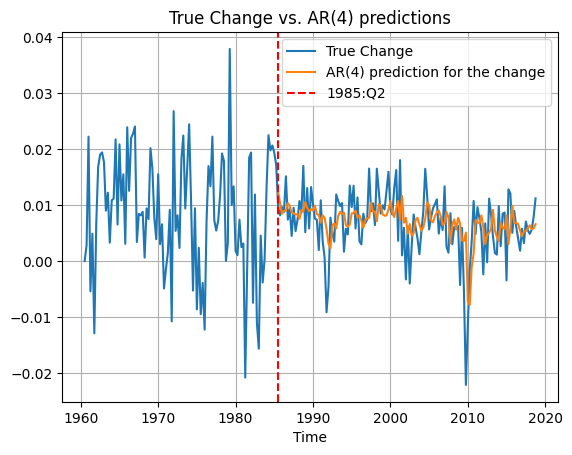

In [35]:
# plt.plot(df['Time'], df['delta_log_GDP'], label='True Change')
# plt.plot(df['Time'].iloc[100:], ar_4_forecasts, label='AR(4) prediction for the change')
# plt.title('True Change vs. AR(4) predictions')
# plt.xlabel('Time')
# plt.grid()
# plt.xlim()
# plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
# plt.legend()

In [82]:
# compute RMSE for AR(4)
# rmse_ar4 = mean_squared_error(df['delta_log_GDP'].iloc[100:], ar_4_forecasts, squared=False).round(2)
# print(rmse_ar4)

Now that we modelled $\Delta \hat{y_{t}}$ with an `AR(4)` model, we have to obtain the values for $\hat{y_{t}}$ coming from the `AR(4)` model.
For this reason, we need to exploit:

$\Delta \hat{y_{h}} = \hat{y}_{t+h} - \hat{y}_{t+h-1}$

$\hat{y}_{t+h} = \Delta \hat{y}_{h} + \hat{y}_{t+h-1}$

Where $\Delta \hat{y}_{h}$ is estimated thanks to the model, and the same for $\hat{y}_{t+h-1}$ which is the previous period, both included into `ar_4_forecasts`.

For loop to derive estimate of GDP from delta GDP: 

In [49]:
ar_4_GDP_estimates = np.zeros(134)
ar_4_GDP_estimates[0] = ar_4_forecasts[0] + df['log_GDP'].iloc[99]

for i in range(1,len(ar_4_GDP_estimates)):
    ar_4_GDP_estimates[i] = ar_4_forecasts[i-1] + ar_4_GDP_estimates[i-1] 

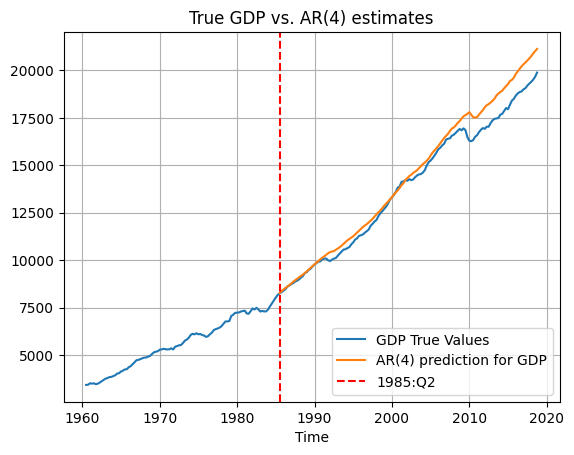

In [52]:
plt.plot(df['Time'], df['GDPC1'], label='GDP True Values')
plt.plot(df['Time'].iloc[100:], np.exp(ar_4_GDP_estimates), label='AR(4) prediction for GDP')
plt.title('True GDP vs. AR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

### **Model: VAR(4)**
For the model VAR(4) we have to forecast $\Delta y_t$, $\pi_t$ and $Tspread_t$. In order to do I will create a new df containing only these 3 series, making it easier to pass them as an argument to the function. 

In [54]:
df_var = df[['Time', 'delta_log_GDP', 'infl', 'tspread']]

In [55]:
df_var = df_var.set_index('Time')

In [88]:
var_4_forecasts = pd.DataFrame(columns=['delta_log_GDP', 'infl', 'tspread'])

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]

    # create the model and fit it
    var_4_model = VAR(current_window) 
    var_4_results = var_4_model.fit(4)

    # forecast the next observation
    var_4_forecast = var_4_results.forecast(y = current_window.values[-4:], steps = 1)[0]
    temp_df = pd.DataFrame({'delta_log_GDP' : [var_4_forecast[0]], 
                            'infl': [var_4_forecast[1]], 
                            'tspread': [var_4_forecast[2]]})

    # append the forecasted value to the list
    var_4_forecasts = pd.concat([var_4_forecasts, temp_df])

    # roll the window
    t += 1

c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

In [89]:
var_4_GDP_estimates = np.zeros(134)
var_4_GDP_estimates[0] = var_4_forecasts['delta_log_GDP'].iloc[0]+ df['log_GDP'].iloc[99]

for i in range(1,len(var_4_GDP_estimates)):
    var_4_GDP_estimates[i] = var_4_forecasts['delta_log_GDP'].iloc[i-1] + var_4_GDP_estimates[i-1] 

var_4_GDP_estimates = np.exp(var_4_GDP_estimates)

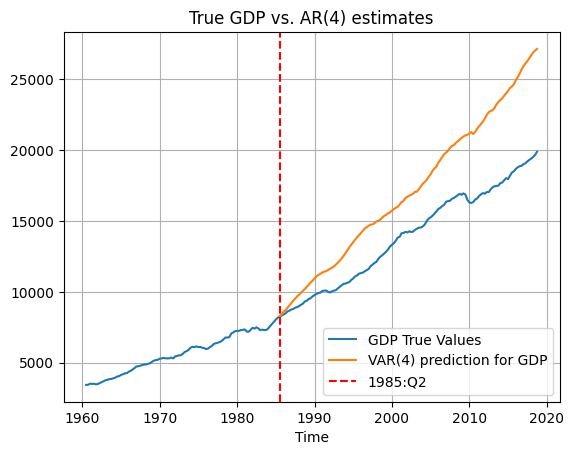

In [91]:
plt.plot(df['Time'], df['GDPC1'], label='GDP True Values')
plt.plot(df['Time'].iloc[100:], var_4_GDP_estimates, label='VAR(4) prediction for GDP')
plt.title('True GDP vs. AR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

### **Model: VAR(p)**

In [ ]:
var_p_forecasts = pd.DataFrame(columns=['delta_log_GDP', 'infl', 'tspread'])

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]

    # create the model and fit it
    var_p_model = VAR(current_window) 
    x = var_p_model.select_order(maxlags=8)
    p = x.selected_orders['aic']

    var_p_results = var_p_model.fit(p)

    # forecast the next observation
    var_p_forecast = var_p_results.forecast(y = current_window.values[-p:], steps = 1)[0]
    temp_df = pd.DataFrame({'delta_log_GDP' : [var_p_forecast[0]], 
                            'infl': [var_p_forecast[1]], 
                            'tspread': [var_p_forecast[2]]})

    # append the forecasted value to the list
    var_p_forecasts = pd.concat([var_p_forecasts, temp_df])

    # roll the window
    t += 1


In [77]:
var_p_GDP_estimates = np.zeros(134)
var_p_GDP_estimates[0] = var_p_forecasts['delta_log_GDP'].iloc[0]+ df['log_GDP'].iloc[99]

for i in range(1,len(var_p_GDP_estimates)):
    var_p_GDP_estimates[i] = var_p_forecasts['delta_log_GDP'].iloc[i-1] + var_p_GDP_estimates[i-1] 

var_p_GDP_estimates = np.exp(var_p_GDP_estimates)

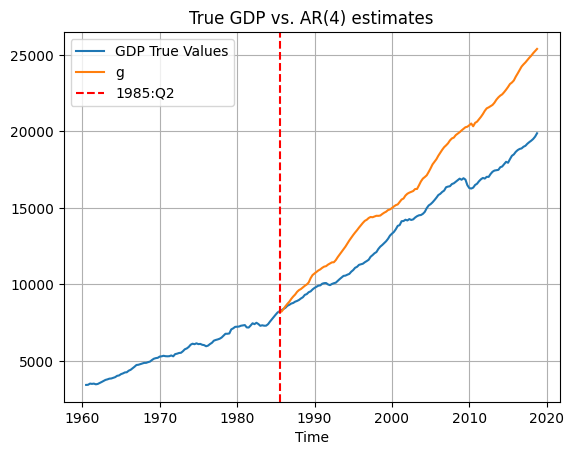

In [79]:
plt.plot(df['Time'], df['GDPC1'], label='GDP True Values')
plt.plot(df['Time'].iloc[100:], var_p_GDP_estimates, label='g')
plt.title('True GDP vs. AR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

### **Model: AR(4)-X**

In [101]:
ar_x_forecasts = []
pca = PCA(n_components=1)

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df.iloc[t:t+window_size]

    # create the model and fit it
    curr_stand_factors = stand_factors[t:t+window_size]

    Pcs = pca.fit_transform(curr_stand_factors)
    Pcs = np.roll(Pcs, 1)
    Pcs[0] = 0
    first_PC = Pcs[-1]

    ar_x_model = SARIMAX(current_window['delta_log_GDP'], exog = Pcs,  order = (4,0,0)) 
        
    ar_x_results = ar_x_model.fit()

    # forecast the next observation
    ar_x_forecast = ar_x_results.forecast(steps=1, exog = first_PC)

    # append the forecasted value to the list
    ar_x_forecasts.append(ar_x_forecast.iloc[0])

    # roll the window
    t += 1


c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [104]:
ar_x_GDP_estimates = np.zeros(134)
ar_x_GDP_estimates[0] = ar_x_forecasts[0] + df['log_GDP'].iloc[99]

for i in range(1,len(ar_x_GDP_estimates)):
    ar_x_GDP_estimates[i] = ar_x_forecasts[i-1] + ar_x_GDP_estimates[i-1] 

ar_x_GDP_estimates = np.exp(ar_x_GDP_estimates)

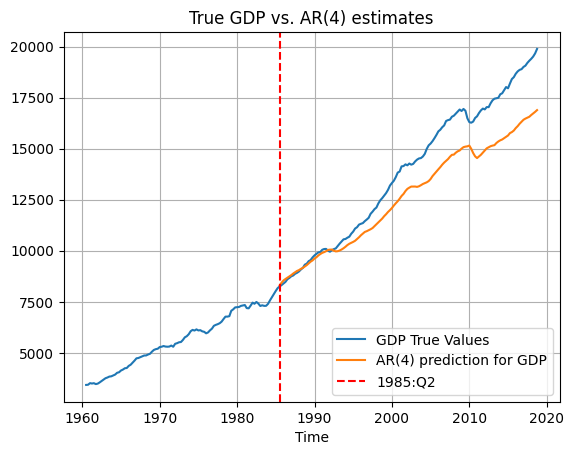

In [105]:
plt.plot(df['Time'], df['GDPC1'], label='GDP True Values')
plt.plot(df['Time'].iloc[100:], ar_x_GDP_estimates, label='AR(4) prediction for GDP')
plt.title('True GDP vs. AR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()